In [96]:
 import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pickle
import timeit
import aesara.tensor as at
from arviz.plots import plot_utils as azpu
import pandas as pd
import decimal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arviz as az
import matplotlib.gridspec as gridspec

from pymc import HalfCauchy, Model, Normal,sample, Uniform
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v5.17.0


In [97]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [98]:
with open('data_c1.pickle', 'rb') as f:
    
   beta_val,K_val,n_val,a1_val,beta1_val,K1_val,n1_val,K2_val,n2_val, a2_val, a3_val,k,x1_0,x2_0,x3_0,fT,t_ori,X1_ssa,X2_ssa,X3_ssa = pickle.load(f)

dt  =t_ori[1]-t_ori[0]
n_seq = len(t_ori)

beta_val,K_val,n_val,a1_val,beta1_val,K1_val,n1_val,K2_val,n2_val, a2_val, a3_val,k

(20, 70, 2, 0.03, 10, 10, 2, 50, 2, 0.01, 0.05, 3)

In [99]:
def return_data(n_data,type_data,t_last):
    # This function is only for bring the data.
    x1_ssa = X1_ssa
    x2_ssa = X2_ssa
    x3_ssa =  X3_ssa
    if type_data == 'ssa':
        x1 = x1_ssa.copy()
        x2 = x2_ssa.copy()
        x3 = x3_ssa.copy()
    XX1 = x1[:-1]
    dXX1 = x1[1:]- x1[:-1]
    XX2 = x2[:-1]
    dXX2 = x2[1:]- x2[:-1]
    XX3 = x3[:-1]
    dXX3 = x3[1:]- x3[:-1]
    
    return XX1[:t_last], dXX1[:t_last], XX2[:t_last], dXX2[:t_last],XX3[:t_last], dXX3[:t_last]

1999
1


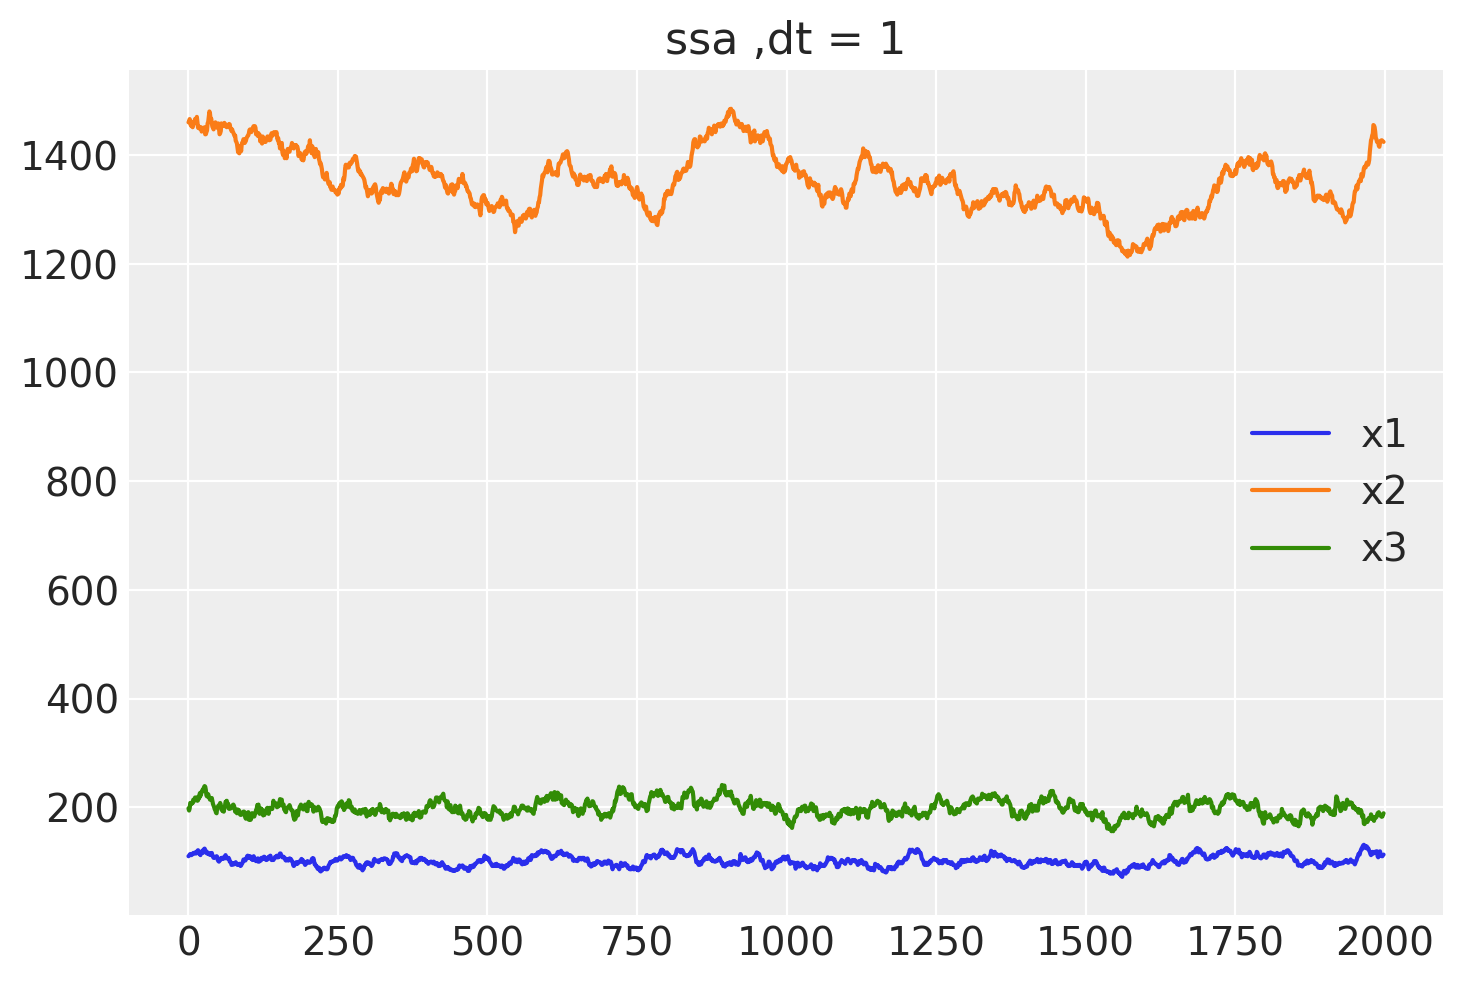

In [100]:
Type_data = ['ssa']
n_type = 0

# decide length of trajectory 
t_last = 1999

# decide dt
DT= [1]
n_dt = 0 

# which trajectories will be used. 
n_data = 0

type_data = Type_data[n_type]
dt = DT[n_dt]
print(len(t_ori[:t_last]))
#print(len(XX1))
#print(dXX1)
#print(dXX2)
#print(dXX3)
print(dt)
XX1, dXX1, XX2, dXX2,XX3,dXX3 = return_data(n_data,type_data,t_last)

plt.plot(t_ori[:t_last],XX1,label = 'x1')
plt.plot(t_ori[:t_last], XX2, label = 'x2')
plt.plot(t_ori[:t_last], XX3, label = 'x3')
plt.title(type_data+' ,dt = %s' %dt)
plt.legend()

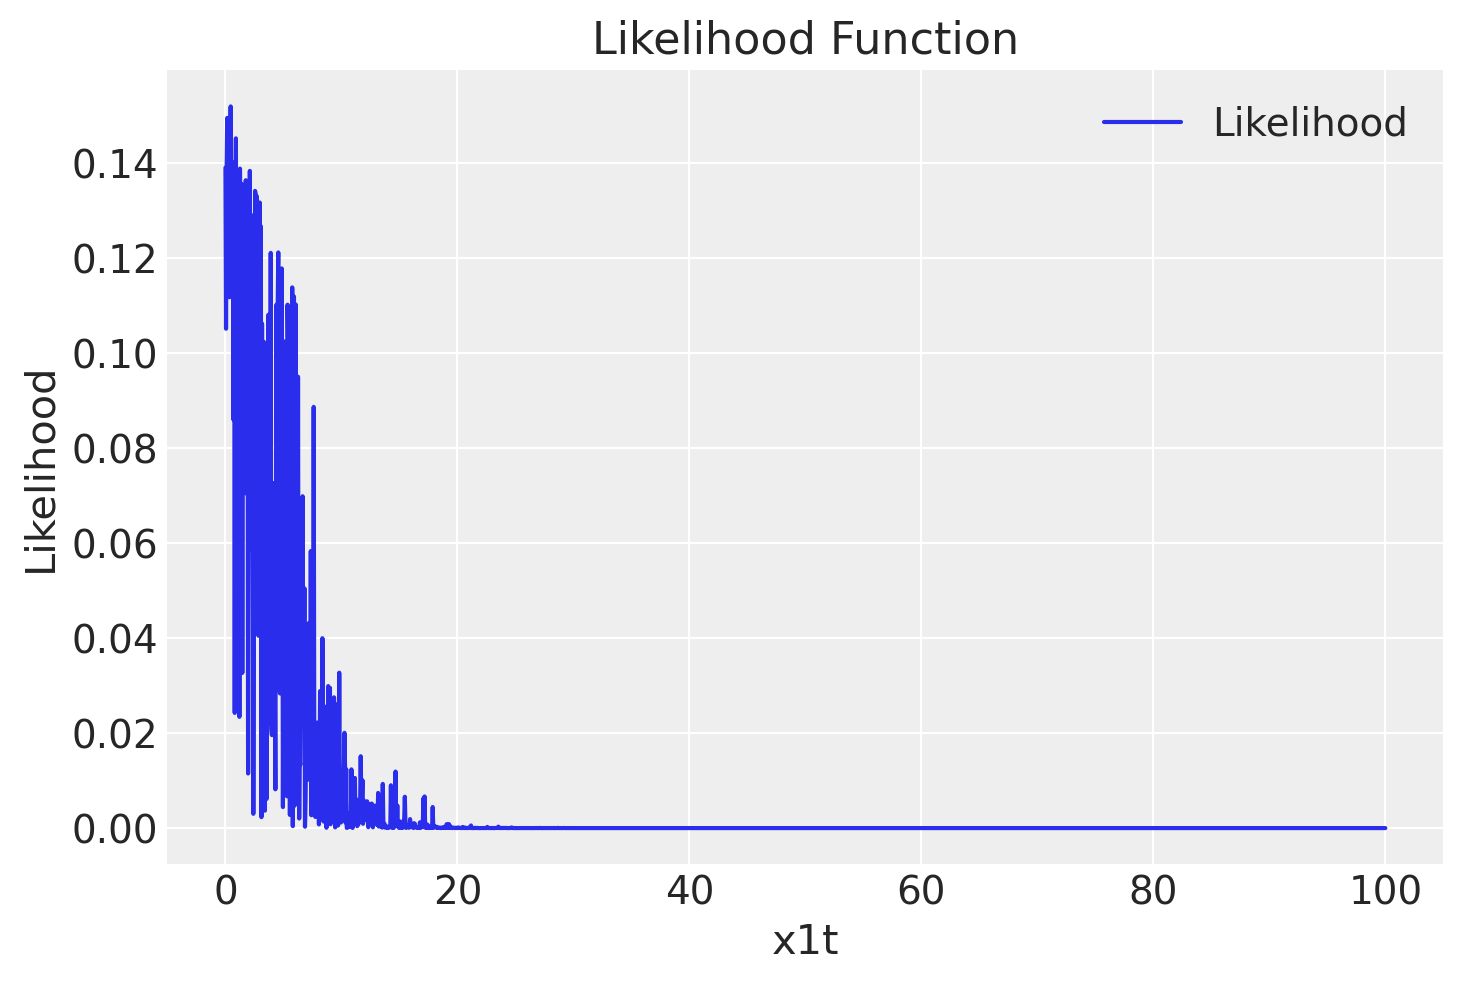

In [109]:

# Fixed parameter values
dt = 1
delta1 = 1
n, n1 = 2, 2
K, K1 = 70,10
beta2, beta3, beta4 = 0, 0, 0
beta5, beta6, beta7, beta8 =  0, 0, 0,0
r1 = 3
a1 = 0.03
beta1=np.linspace(0,100,1999)
# Independent variable ranges
x1t = XX1
x2t = XX2
x3t =XX3
dx1t=dXX1
# Compute F1
F1 = dt * (
    delta1 * (
        beta1 * (x2t**n) / (x2t**n + K**n) +
        beta2 * (K**n) / (x2t**n + K**n) +
        beta3 * (x3t**n1) / (x3t**n1 + K1**n1) +
        beta4 * (K1**n1) / (x3t**n1 + K1**n1)
    ) +
    (1 - delta1) * (
        beta5 * (x2t**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)) +
        beta6 * (K**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)) +
        beta7 * (x2t**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)) +
        beta8 * (K**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))
    )
) + r1 - a1 * x1t

# Compute G1
G1 = np.sqrt(dt) * (
    np.sqrt(
        delta1 * (
            abs(beta1 * (x2t**n) / (x2t**n + K**n)) +
            abs(beta2 * (K**n) / (x2t**n + K**n)) +
            abs(beta3 * (x3t**n1) / (x3t**n1 + K1**n1)) +
            abs(beta4 * (K1**n1) / (x3t**n1 + K1**n1))
        ) +
        (1 - delta1) * (
            abs(beta5 * (x2t**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))) +
            abs(beta6 * (K**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))) +
            abs(beta7 * (x2t**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))) +
            abs(beta8 * (K**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)))
        ) +
        abs(r1) +
        abs(a1 * x1t)
    )
)

# Likelihood function

likelihood = (1 / (np.sqrt(2 * np.pi) * G1)) * np.exp(-0.5 * ((dx1t - F1) / G1)**2)

# Plot the likelihood
plt.plot( beta1,likelihood, label='Likelihood')
plt.xlabel('x1t')
plt.ylabel('Likelihood')
plt.title('Likelihood Function')
plt.legend()
plt.show()


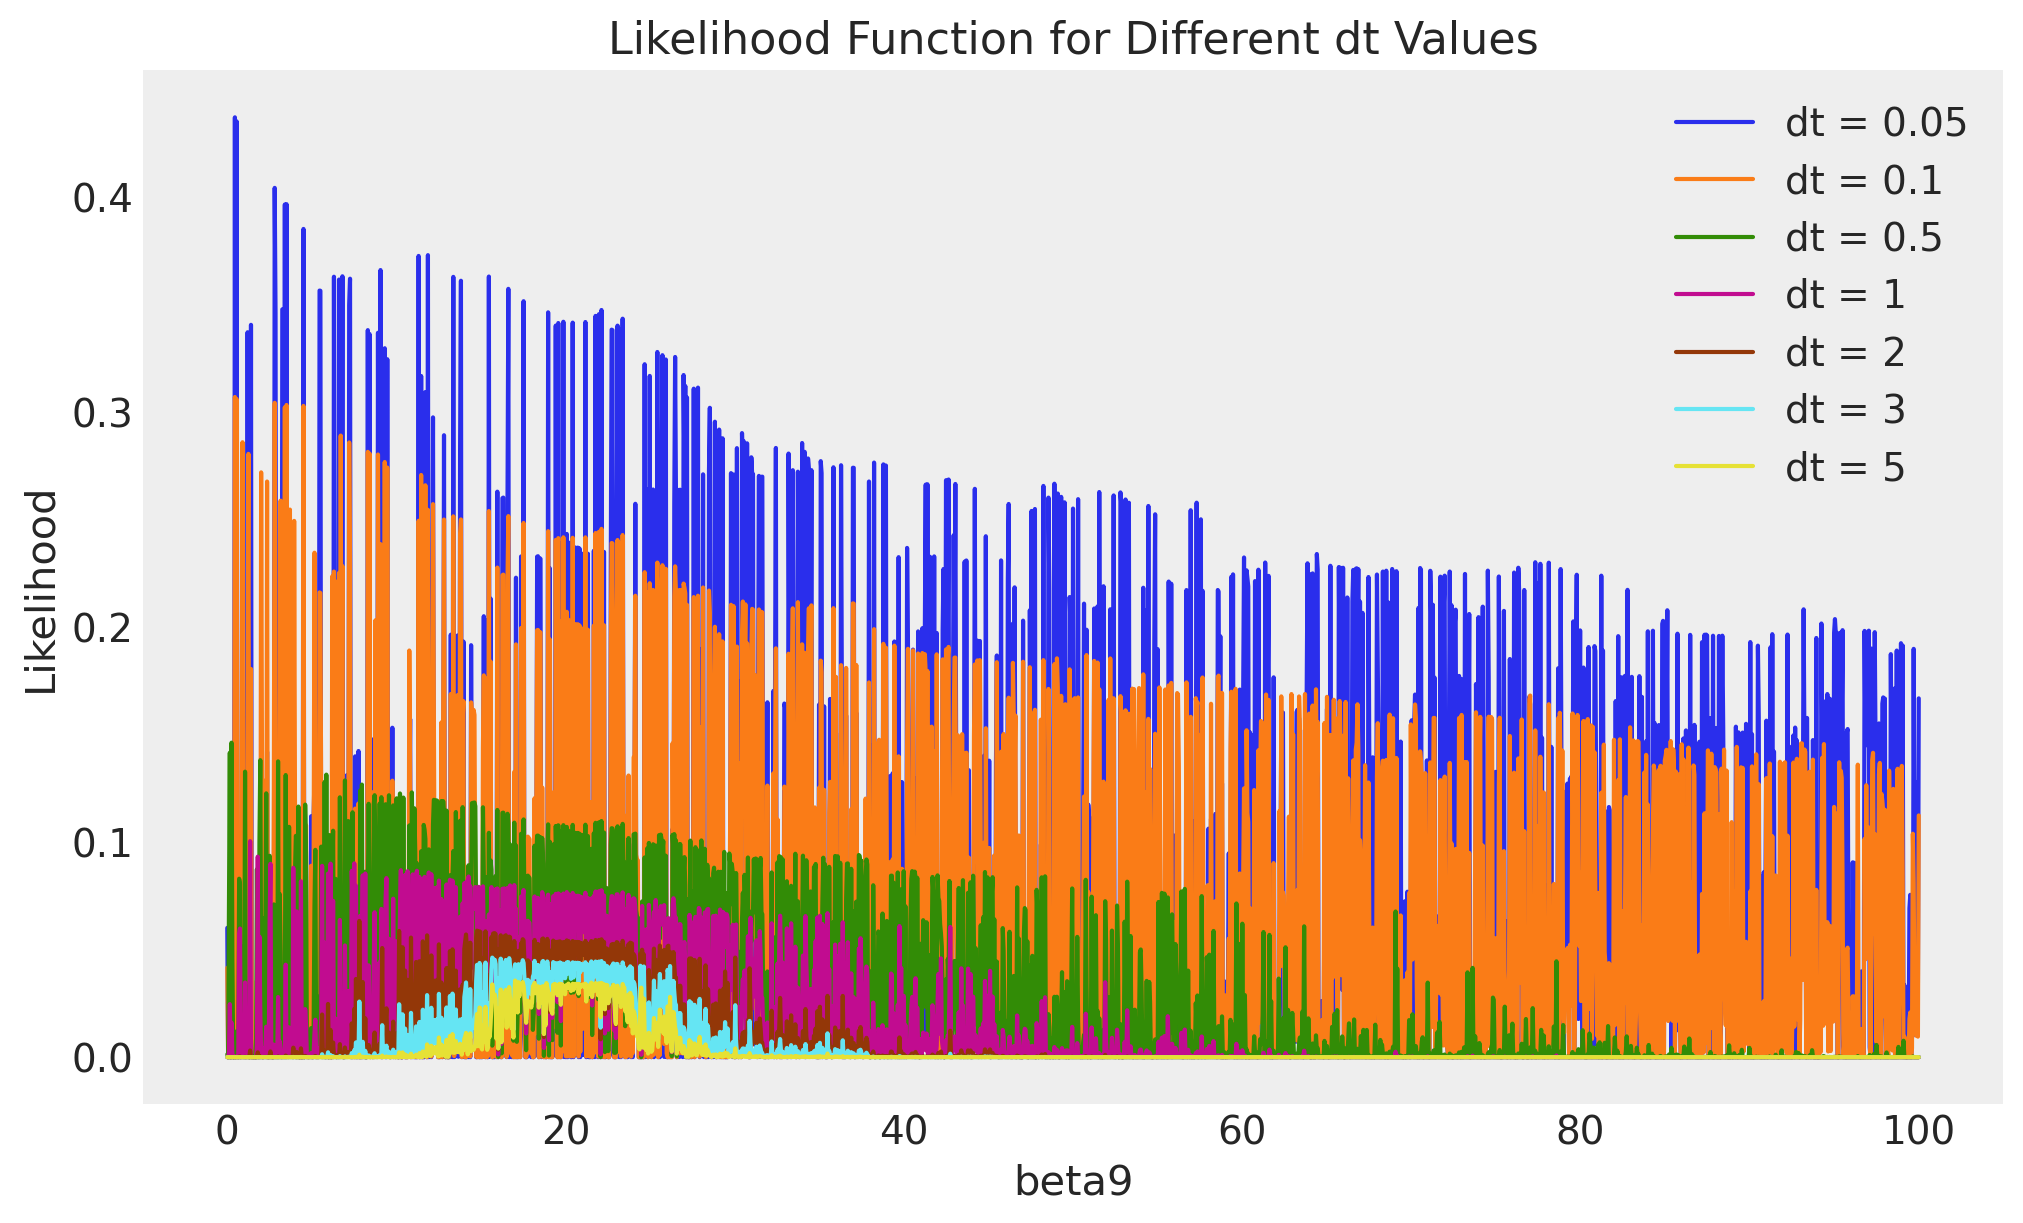

In [112]:

# Parameters
delta2 = 1
n, n2 = 2, 2
K, K1, K2 = 70, 10, 50
beta10, beta11, beta12 = 0, 0, 0
beta13, beta14, beta15, beta16 = 0, 0, 0, 0
beta9 = np.linspace(0, 100, 1999) 
r2=0
a2=0.01
# Independent variable ranges
x1t = XX1
x2t = XX2
x3t =XX3
dx2t=dXX2
# Values of dt to iterate over
dt_values = [0.05,0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F2
    F2 = dt * (
        delta2 * (
            beta9 * (x1t**n) / (x1t**n + K**n) +
            beta10 * (K**n) / (x1t**n + K**n) +
            beta11 * (x3t**n2) / (x3t**n2 + K2**n2) +
            beta12 * (K2**n2) / (x3t**n2 + K2**n2)
        ) +
        (1 - delta2) * (
            beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))
        ) -
        a2 * x2t + r2
    )

    # Compute G2
    G2 = np.sqrt(dt) * (
        np.sqrt(
            delta2 * (
                abs(beta9 * (x1t**n) / (x1t**n + K**n)) +
                abs(beta10 * (K**n) / (x1t**n + K**n)) +
                abs(beta11 * (x3t**n2) / (x3t**n2 + K2**n2)) +
                abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
            ) +
            (1 - delta2) * (
                abs(beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)))
            ) +
            abs(a2 * x2t) + r2
        )
    )

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)

    # Plot likelihood
    plt.plot(beta9, likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('beta9')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()


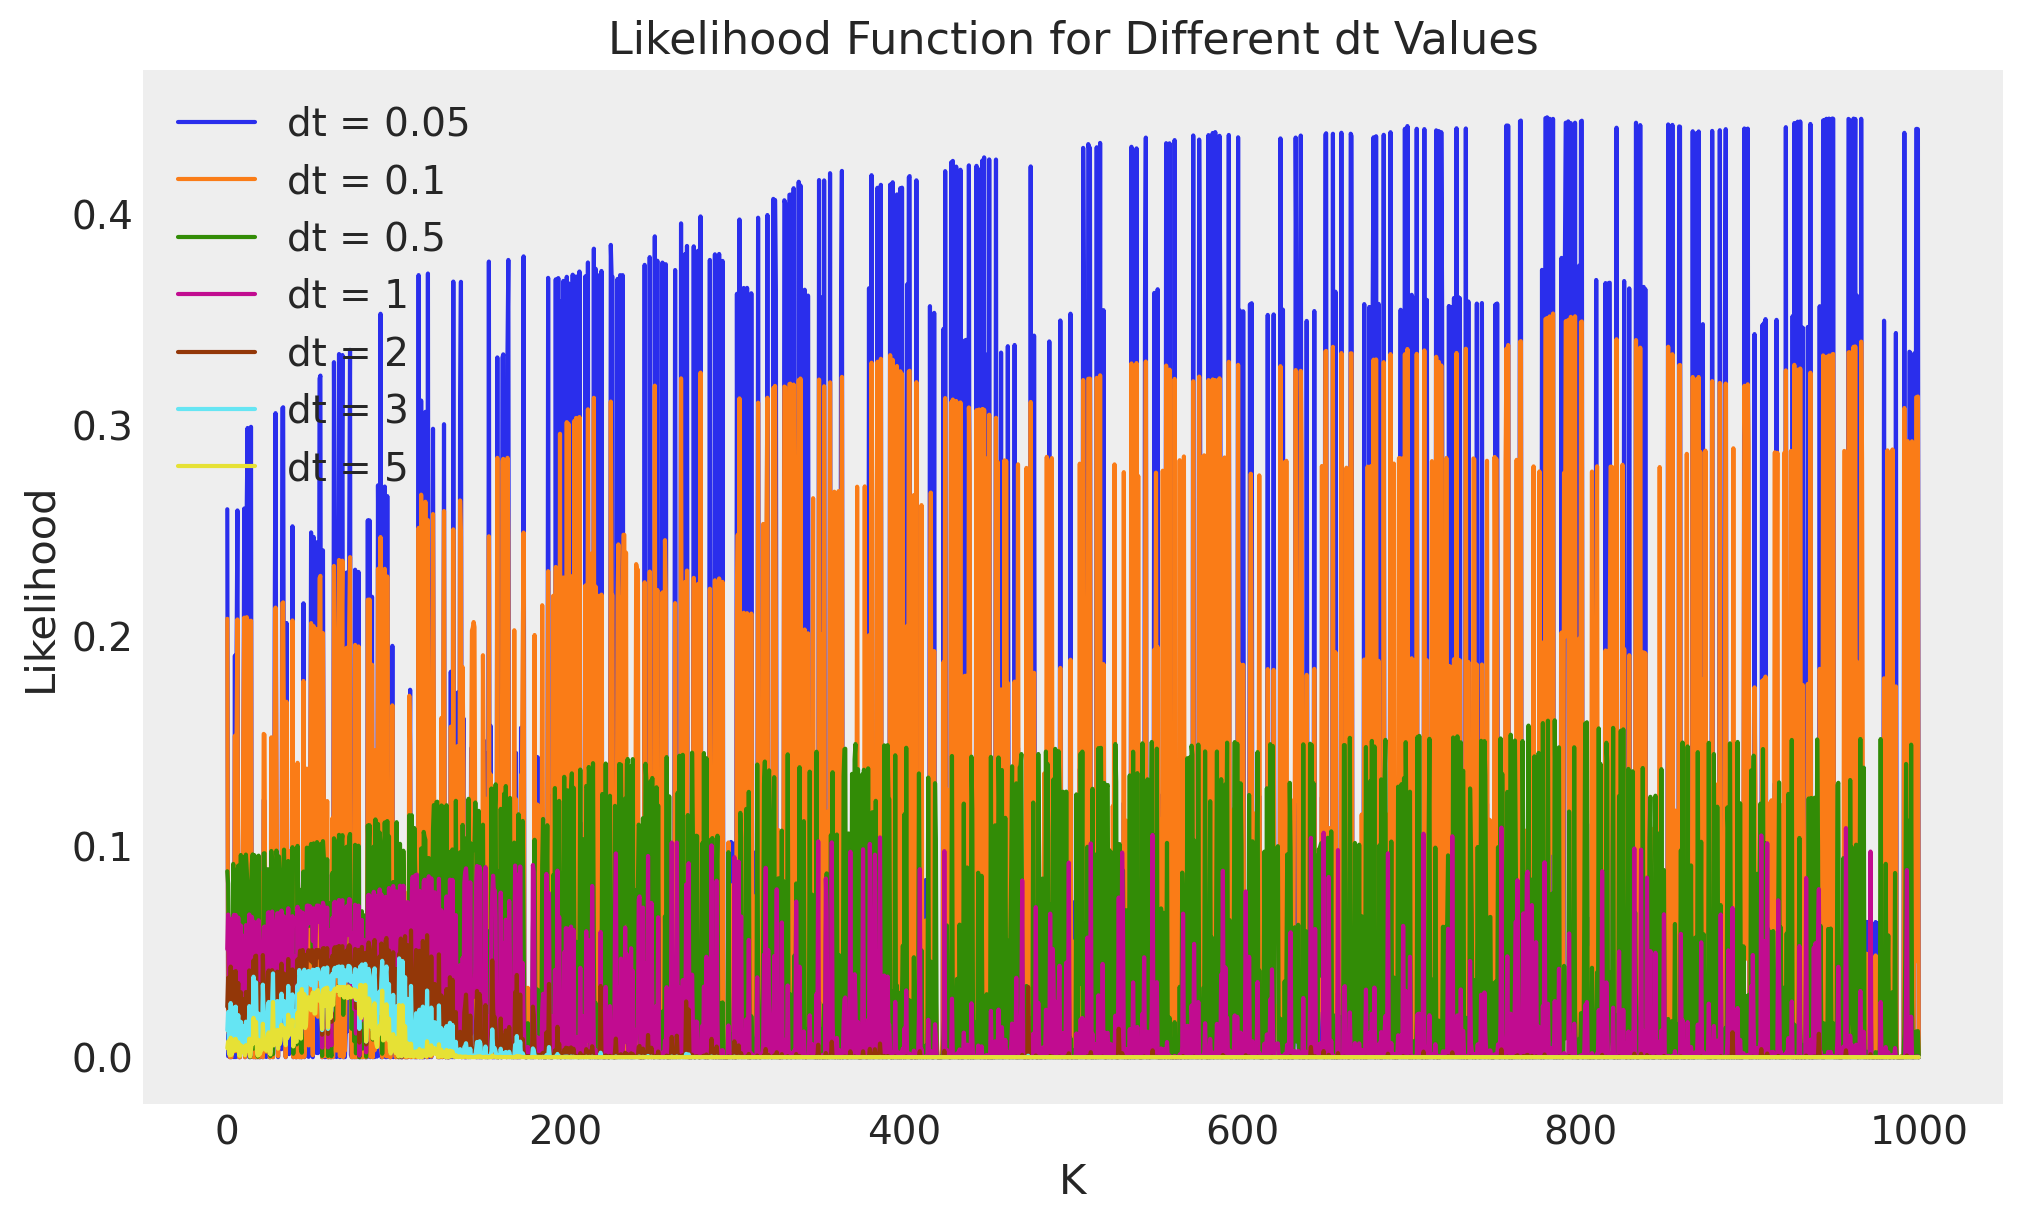

In [127]:
delta2 = 1
n, n2 = 2, 2
K1, K2 =  10, 50
beta10, beta11, beta12 = 0, 0, 0
beta13, beta14, beta15, beta16 = 0, 0, 0, 0
beta9 = 20 
K=np.linspace(0, 1000, 1999) 
r2=0
a2=0.01
# Independent variable ranges
x1t = XX1
x2t = XX2
x3t =XX3
dx2t=dXX2
# Values of dt to iterate over
dt_values = [0.05,0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F2
    F2 = dt * (
        delta2 * (
            beta9 * (x1t**n) / (x1t**n + K**n) +
            beta10 * (K**n) / (x1t**n + K**n) +
            beta11 * (x3t**n2) / (x3t**n2 + K2**n2) +
            beta12 * (K2**n2) / (x3t**n2 + K2**n2)
        ) +
        (1 - delta2) * (
            beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))
        ) -
        a2 * x2t + r2
    )

    # Compute G2
    G2 = np.sqrt(dt) * (
        np.sqrt(
            delta2 * (
                abs(beta9 * (x1t**n) / (x1t**n + K**n)) +
                abs(beta10 * (K**n) / (x1t**n + K**n)) +
                abs(beta11 * (x3t**n2) / (x3t**n2 + K2**n2)) +
                abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
            ) +
            (1 - delta2) * (
                abs(beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)))
            ) +
            abs(a2 * x2t) + r2
        )
    )

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)

    # Plot likelihood
    plt.plot(K, likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('K')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()


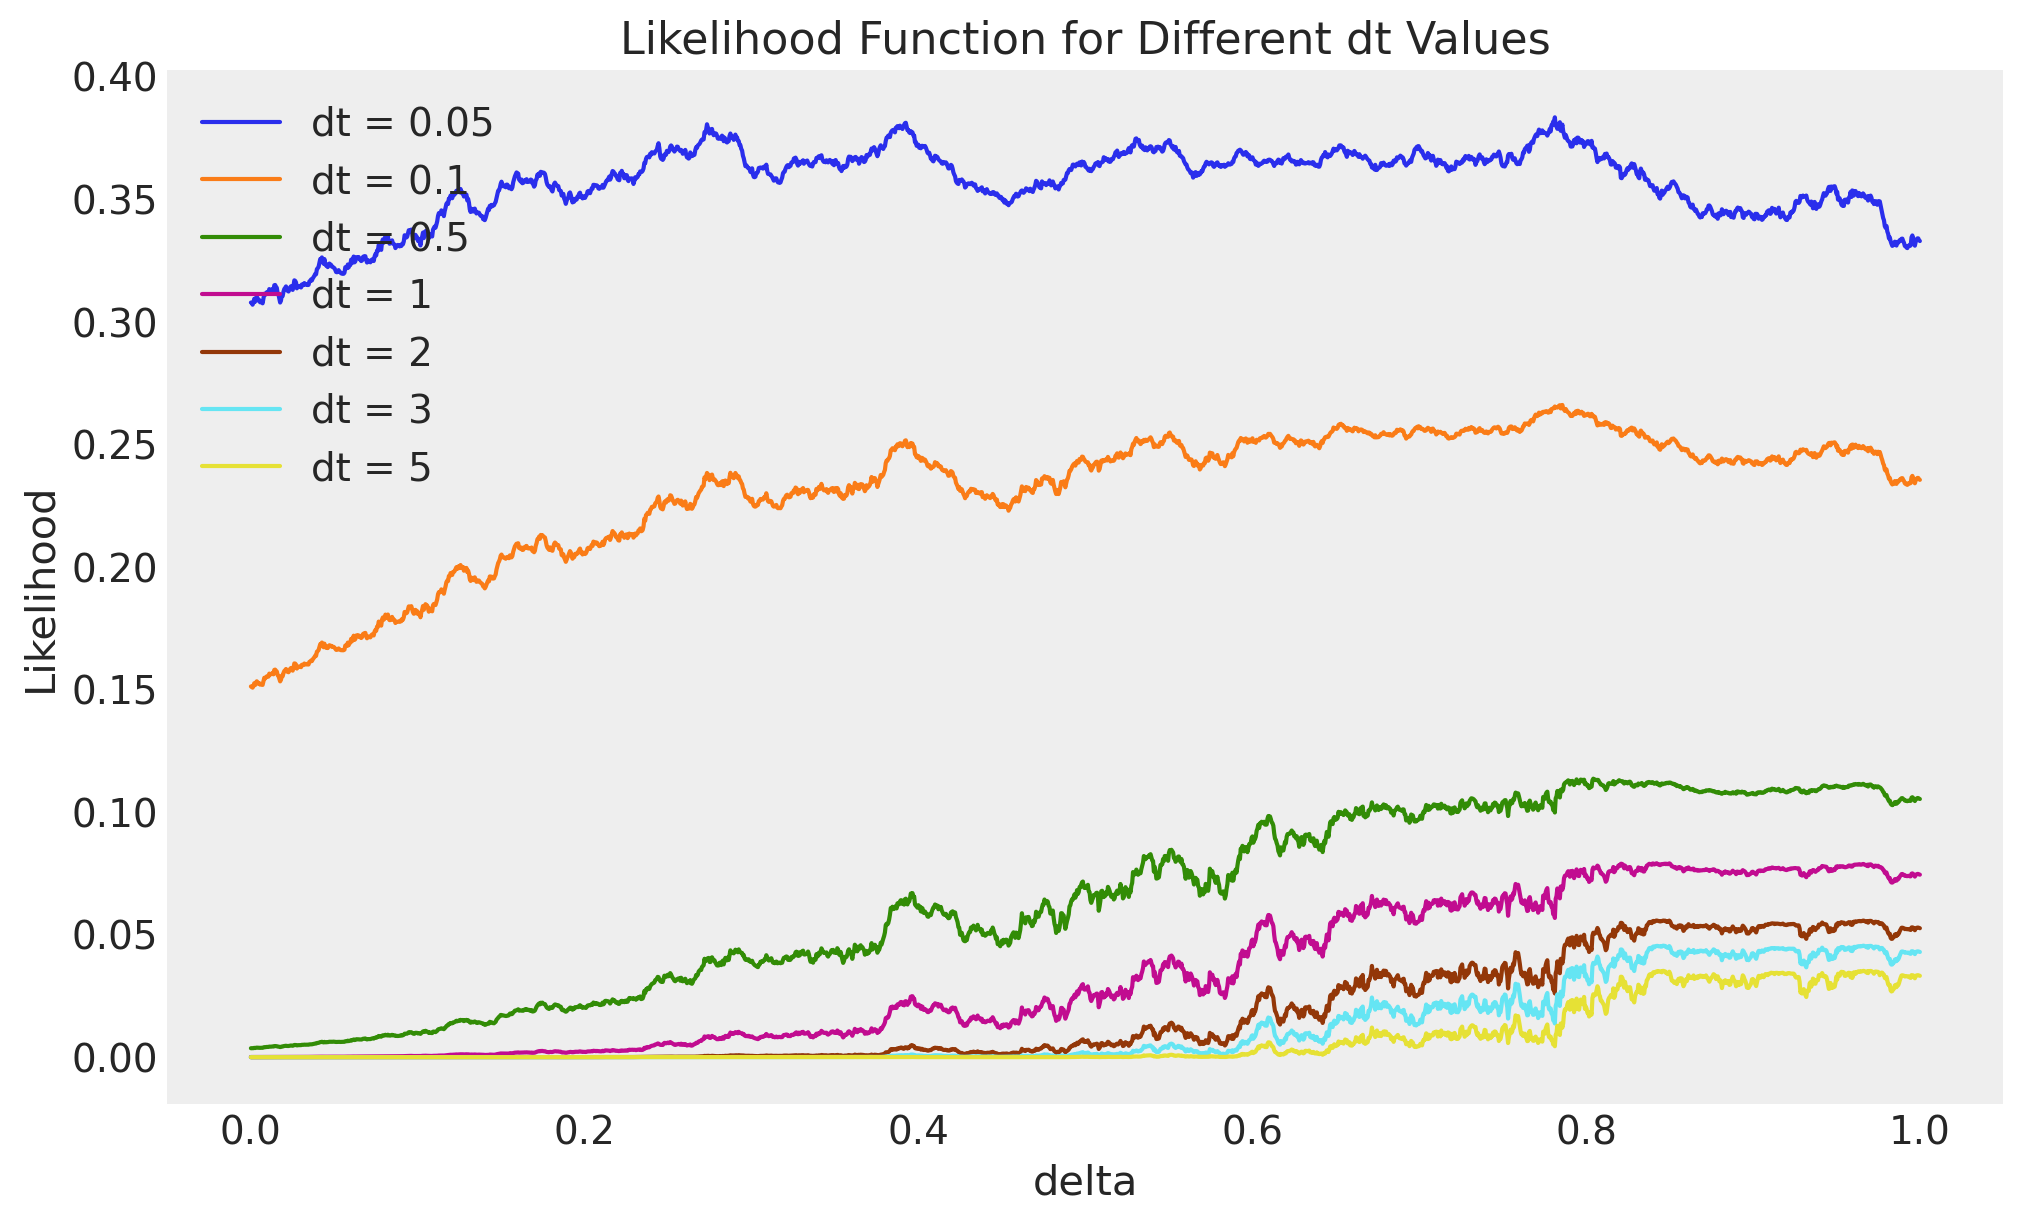

In [91]:
delta2 = np.linspace(0,1,1999)
n, n2 = 2, 2
K1, K2 =  10, 50
beta10, beta11, beta12 = 0, 0, 0
beta13, beta14, beta15, beta16 = 0, 0, 0, 0
beta9 = 20 
K=70
r2=0
a2=0.01
# Independent variable ranges
x1t = XX1
x2t = XX2
x3t =XX3
# Values of dt to iterate over
dt_values = [0.05,0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F2
    F2 = dt * (
        delta2 * (
            beta9 * (x1t**n) / (x1t**n + K**n) +
            beta10 * (K**n) / (x1t**n + K**n) +
            beta11 * (x3t**n2) / (x3t**n2 + K2**n2) +
            beta12 * (K2**n2) / (x3t**n2 + K2**n2)
        ) +
        (1 - delta2) * (
            beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))
        ) -
        a2 * x2t + r2
    )

    # Compute G2
    G2 = np.sqrt(dt) * (
        np.sqrt(
            delta2 * (
                abs(beta9 * (x1t**n) / (x1t**n + K**n)) +
                abs(beta10 * (K**n) / (x1t**n + K**n)) +
                abs(beta11 * (x3t**n2) / (x3t**n2 + K2**n2)) +
                abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
            ) +
            (1 - delta2) * (
                abs(beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)))
            ) +
            abs(a2 * x2t) + r2
        )
    )

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)

    # Plot likelihood
    plt.plot(delta2, likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('delta')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()


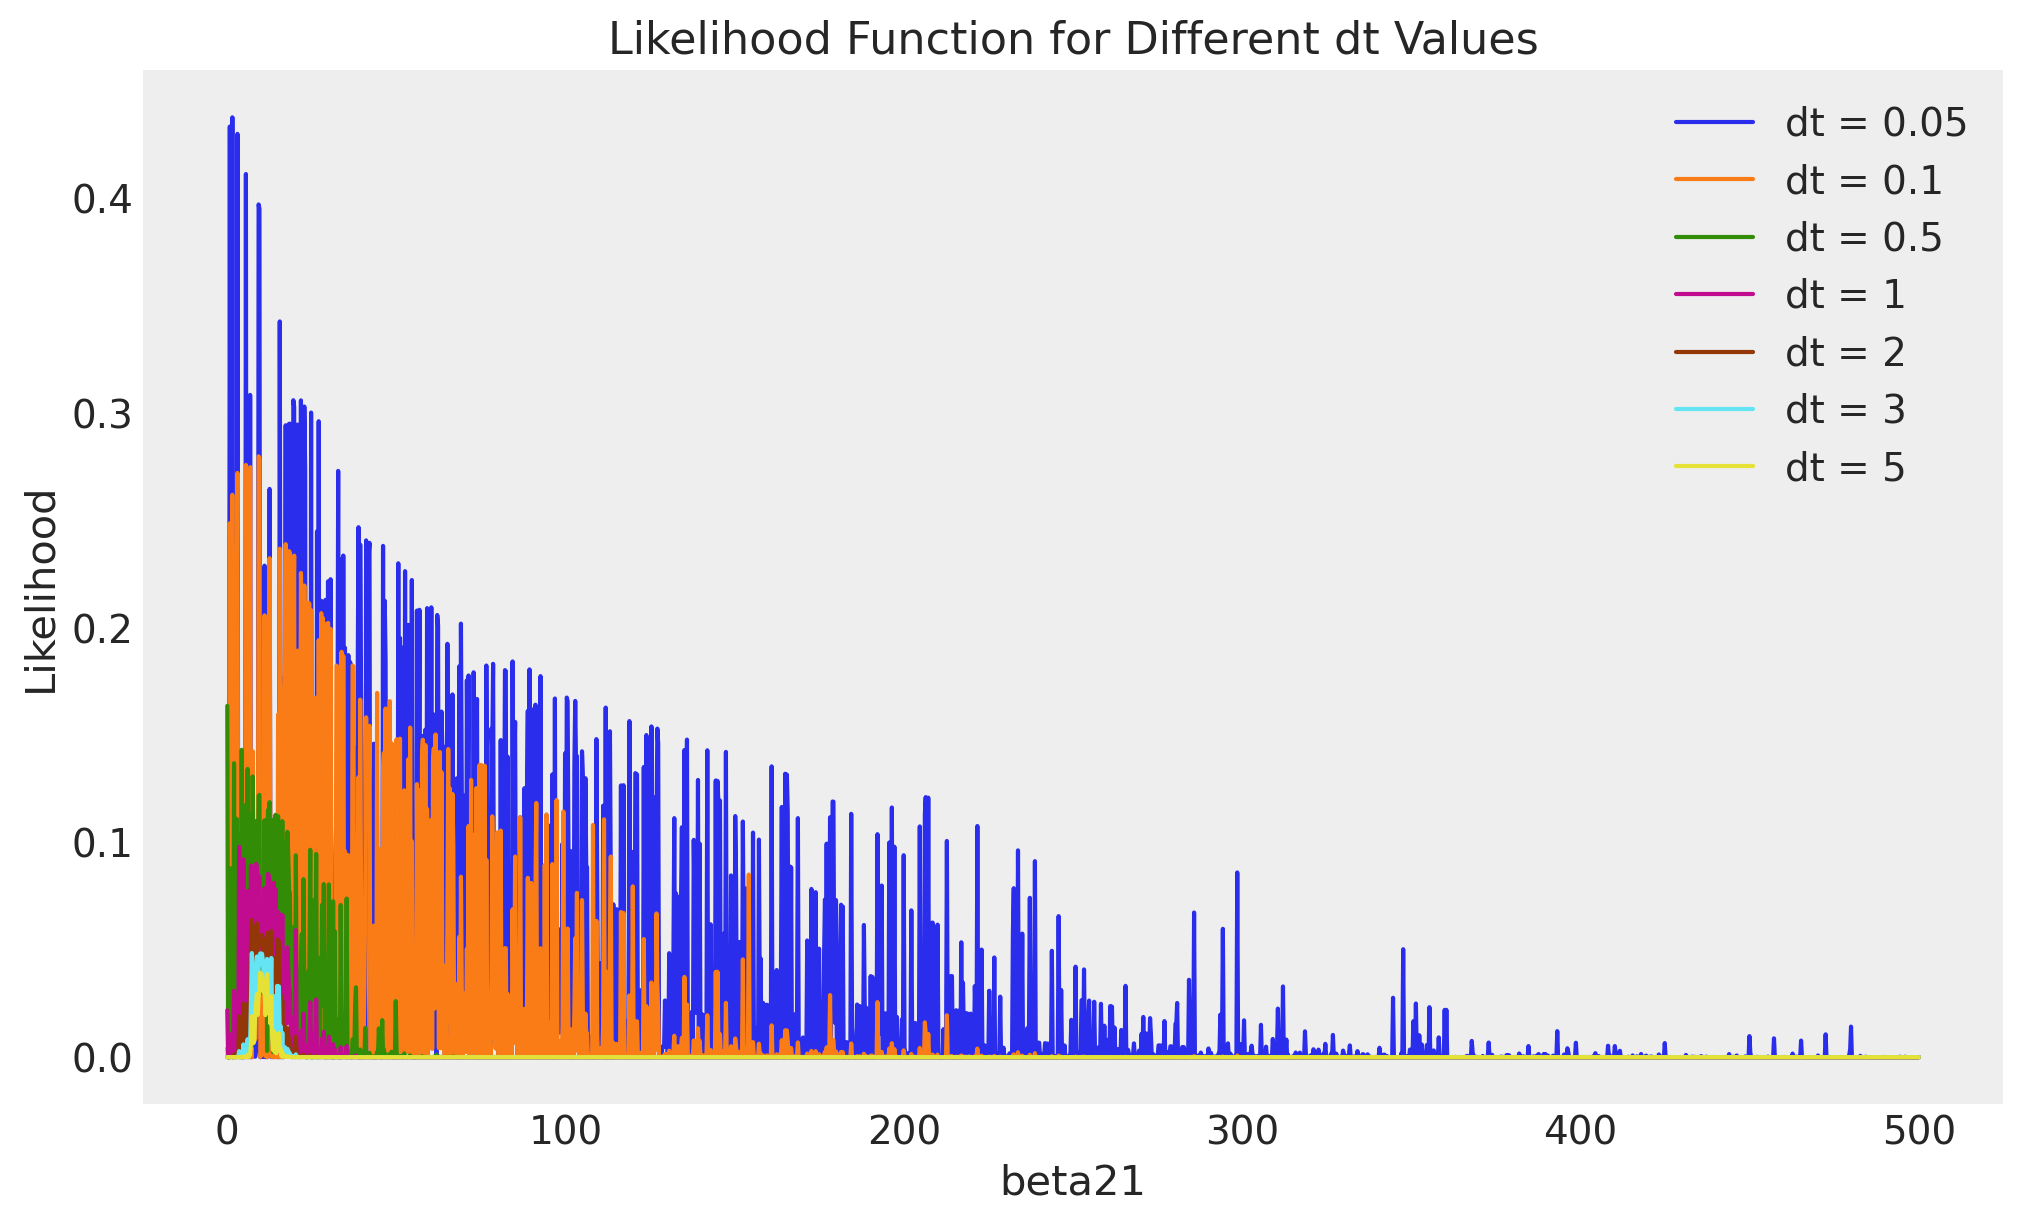

In [124]:
delta3 = 0
n, n2 = 2, 2
K1, K2 =  10, 50
beta17, beta18, beta19,beta20 = 0, 0, 0,0
beta22,beta23, beta24 = 0, 0,0
beta21=20
a3=0.05
beta21=np.linspace(0, 500, 1999) 
r3=0

# Independent variable ranges
x1t = XX1
x2t = XX2
x3t =XX3
dx3t=dXX3
# Values of dt to iterate over
dt_values = [0.05,0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F3
    F3 = dt *  (delta3*(beta17 * (x1t**n1) / (x1t**n1 + K1**n1) +
                    beta18 * (K1**n1) / (x1t**n1 + K1**n1) + 
                    beta19 * (x2t**n2) / (x2t**n2 + K2**n2) + 
                    beta20 * (K2**n2) / (x2t**n2 + K2**n2))+
        
       (1-delta3)*( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2))))
        
        -a3 * x3t+r3)

    # Compute G3
    G3 =  G3= np.sqrt(dt) * (
         np.sqrt(delta3*(abs(beta17 * (x1t**n1) / (x1t**n1 + K1**n1)) +
                                  abs( beta18 * (K1**n1) / (x1t**n1 + K1**n1)) +
                                  abs( beta19 * (x2t**n2) / (x2t**n2 + K2**n2)) +
                                   abs(beta20 * (K2**n2) / (x2t**n2 + K2**n2)))+
       
            (1-delta3)*(abs( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            abs( beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            abs(beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            abs(  beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))))+
        
        abs(a3 * x3t)+r3))
    
        

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G3)) * np.exp(-0.5 * ((dx3t - F3) / G3)**2)

    # Plot likelihood
    plt.plot(beta21, likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('beta21')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()


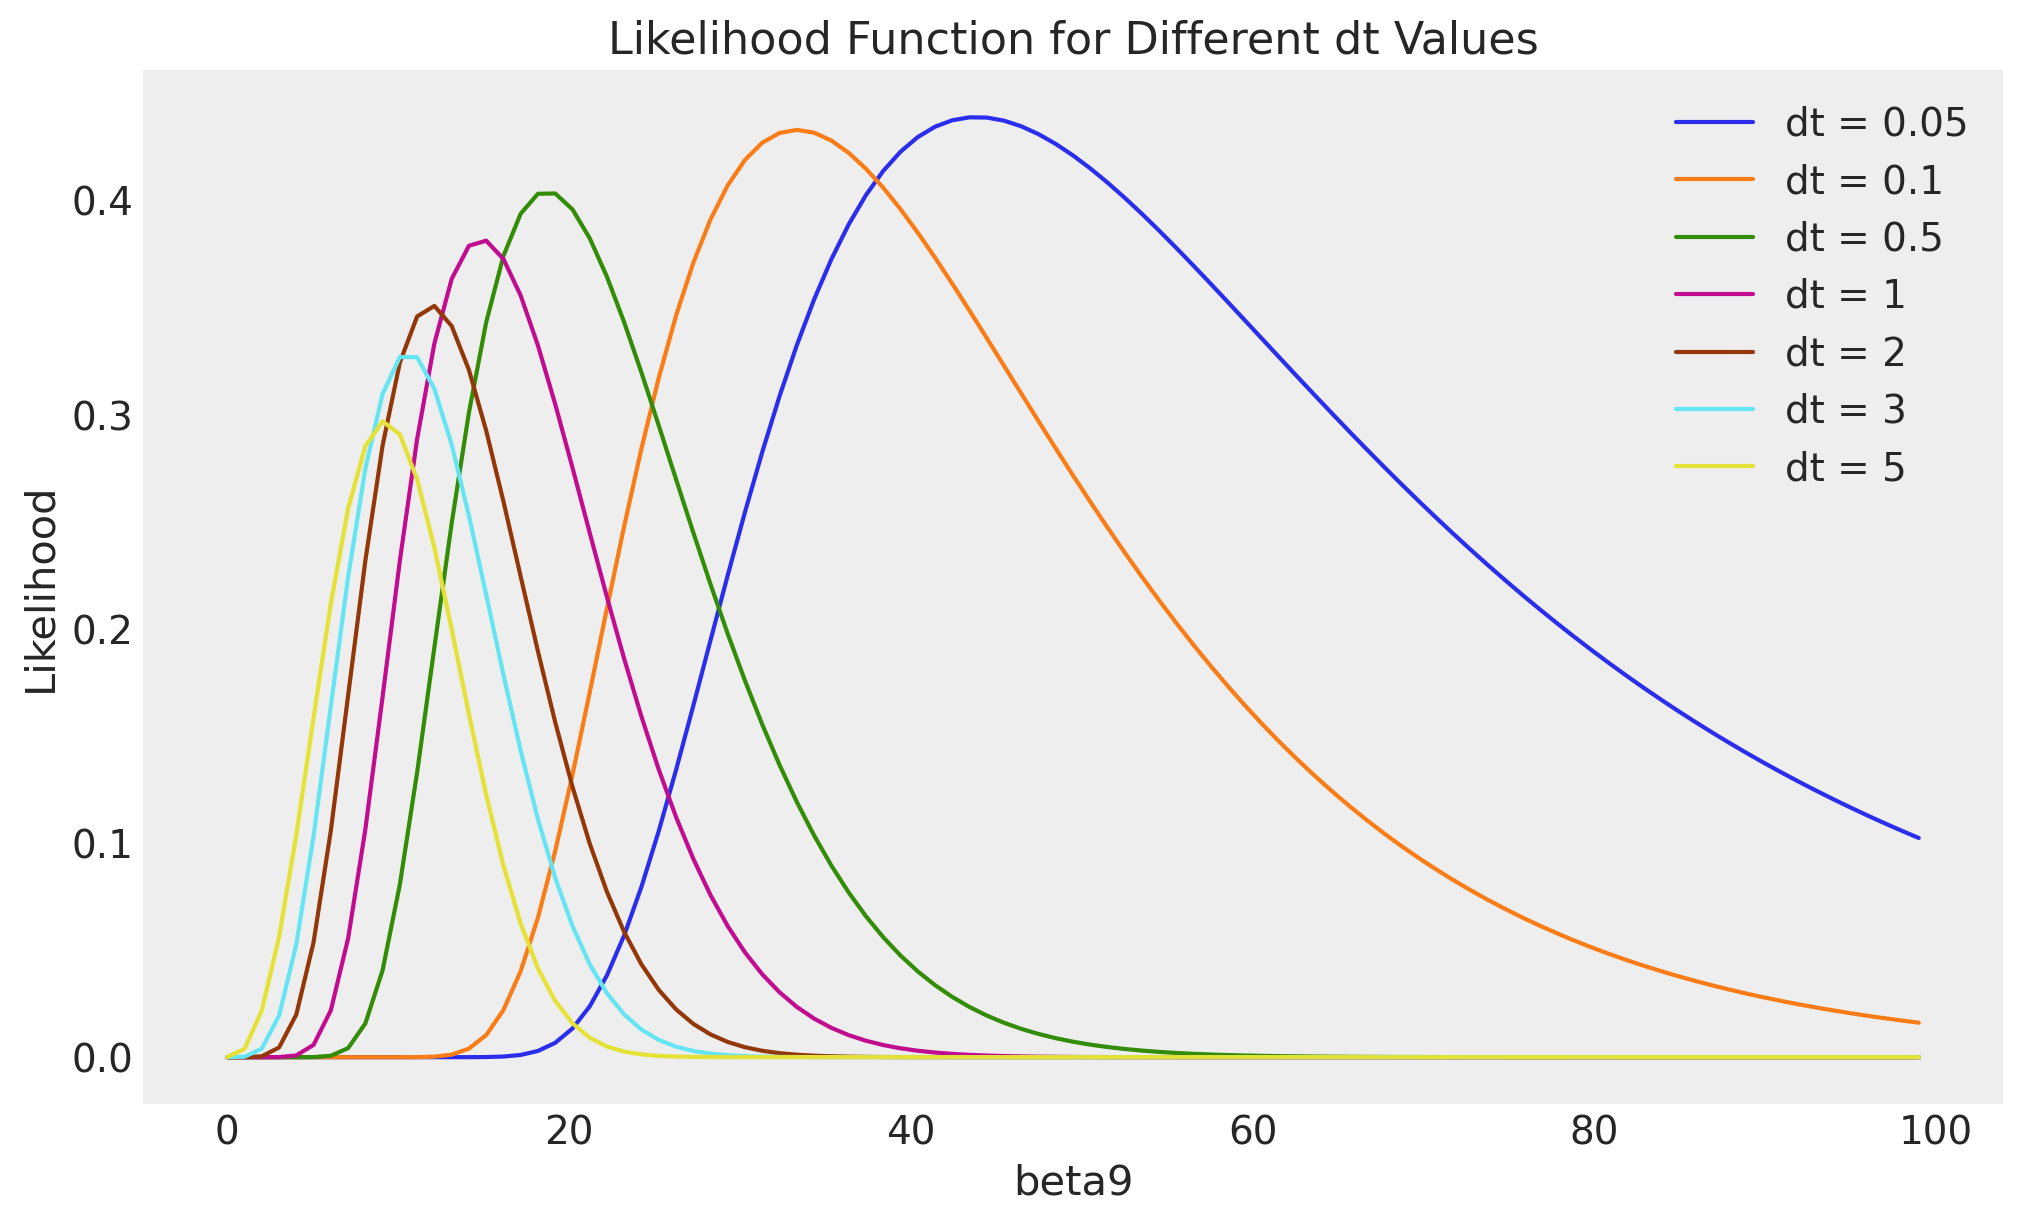

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
delta2 = 1
n, n2 = 2, 2
K1, K2 = 10, 50
beta10, beta11, beta12 = 0, 0, 0
beta13, beta14, beta15, beta16 = 0, 0, 0, 0
K =70 
beta9 = np.linspace(0, 100, 100) 
r2 = 0
a2 = 0.01

# Independent variable ranges
x1t = np.linspace(1, 100, 100)
x2t = np.linspace(1, 100, 100)
x3t = np.linspace(1, 100, 100)
dx2t = x2t[1:] - x2t[:-1]  

# Values of dt to iterate over
dt_values = [0.05, 0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F2
    F2 = dt * (
        delta2 * (
            beta9 * (x1t**n) / (x1t**n + K**n) +
            beta10 * (K**n) / (x1t**n + K**n) +
            beta11 * (x3t**n2) / (x3t**n2 + K2**n2) +
            beta12 * (K2**n2) / (x3t**n2 + K2**n2)
        ) -
        a2 * x2t + r2
    )
    
    # Compute G2
    G2 = np.sqrt(dt) * np.sqrt(
        delta2 * (
            abs(beta9 * (x1t**n) / (x1t**n + K**n)) +
            abs(beta10 * (K**n) / (x1t**n + K**n)) +
            abs(beta11 * (x3t**n2) / (x3t**n2 + K2**n2)) +
            abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
        ) +
        abs(a2 * x2t) + r2
    )
    
    # Ensure F2 and G2 match the size of dx2t
    F2 = F2[:-1]
    G2 = G2[:-1]

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)
    
    # Plot likelihood
    plt.plot(beta9[:-1], likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('beta9')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()


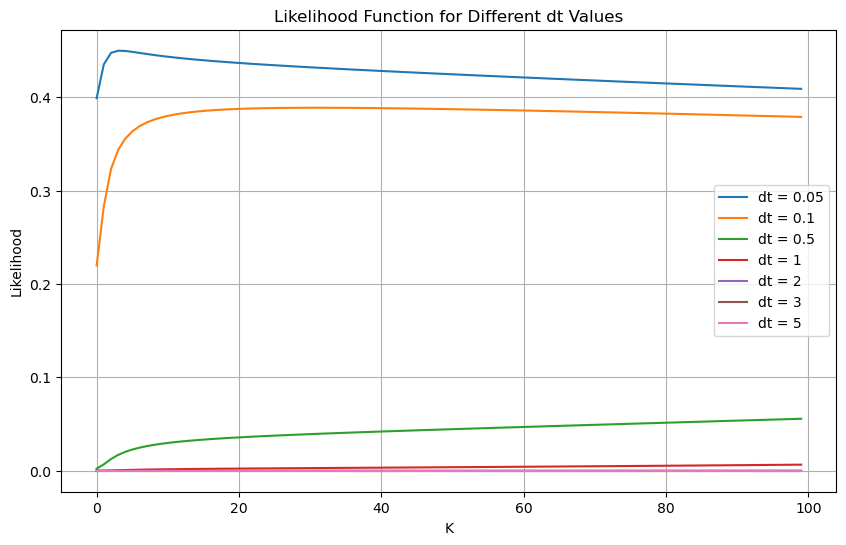

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
delta2 = 1
n, n2 = 2, 2
K1, K2 = 10, 50
beta10, beta11, beta12 = 0, 0, 0
beta13, beta14, beta15, beta16 = 0, 0, 0, 0
K =np.linspace(0, 100, 100) 
beta9 = 20
r2 = 0
a2 = 0.01

# Independent variable ranges
x1t = np.linspace(1, 100, 100)
x2t = np.linspace(1, 100, 100)
x3t = np.linspace(1, 100, 100)
dx2t = x2t[1:] - x2t[:-1]  

# Values of dt to iterate over
dt_values = [0.05, 0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F2
    F2 = dt * (
        delta2 * (
            beta9 * (x1t**n) / (x1t**n + K**n) +
            beta10 * (K**n) / (x1t**n + K**n) +
            beta11 * (x3t**n2) / (x3t**n2 + K2**n2) +
            beta12 * (K2**n2) / (x3t**n2 + K2**n2)
        ) -
        a2 * x2t + r2
    )
    
    # Compute G2
    G2 = np.sqrt(dt) * np.sqrt(
        delta2 * (
            abs(beta9 * (x1t**n) / (x1t**n + K**n)) +
            abs(beta10 * (K**n) / (x1t**n + K**n)) +
            abs(beta11 * (x3t**n2) / (x3t**n2 + K2**n2)) +
            abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
        ) +
        abs(a2 * x2t) + r2
    )
    
    # Ensure F2 and G2 match the size of dx2t
    F2 = F2[:-1]
    G2 = G2[:-1]

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)
    
    # Plot likelihood
    plt.plot(K[:-1], likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('K')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()


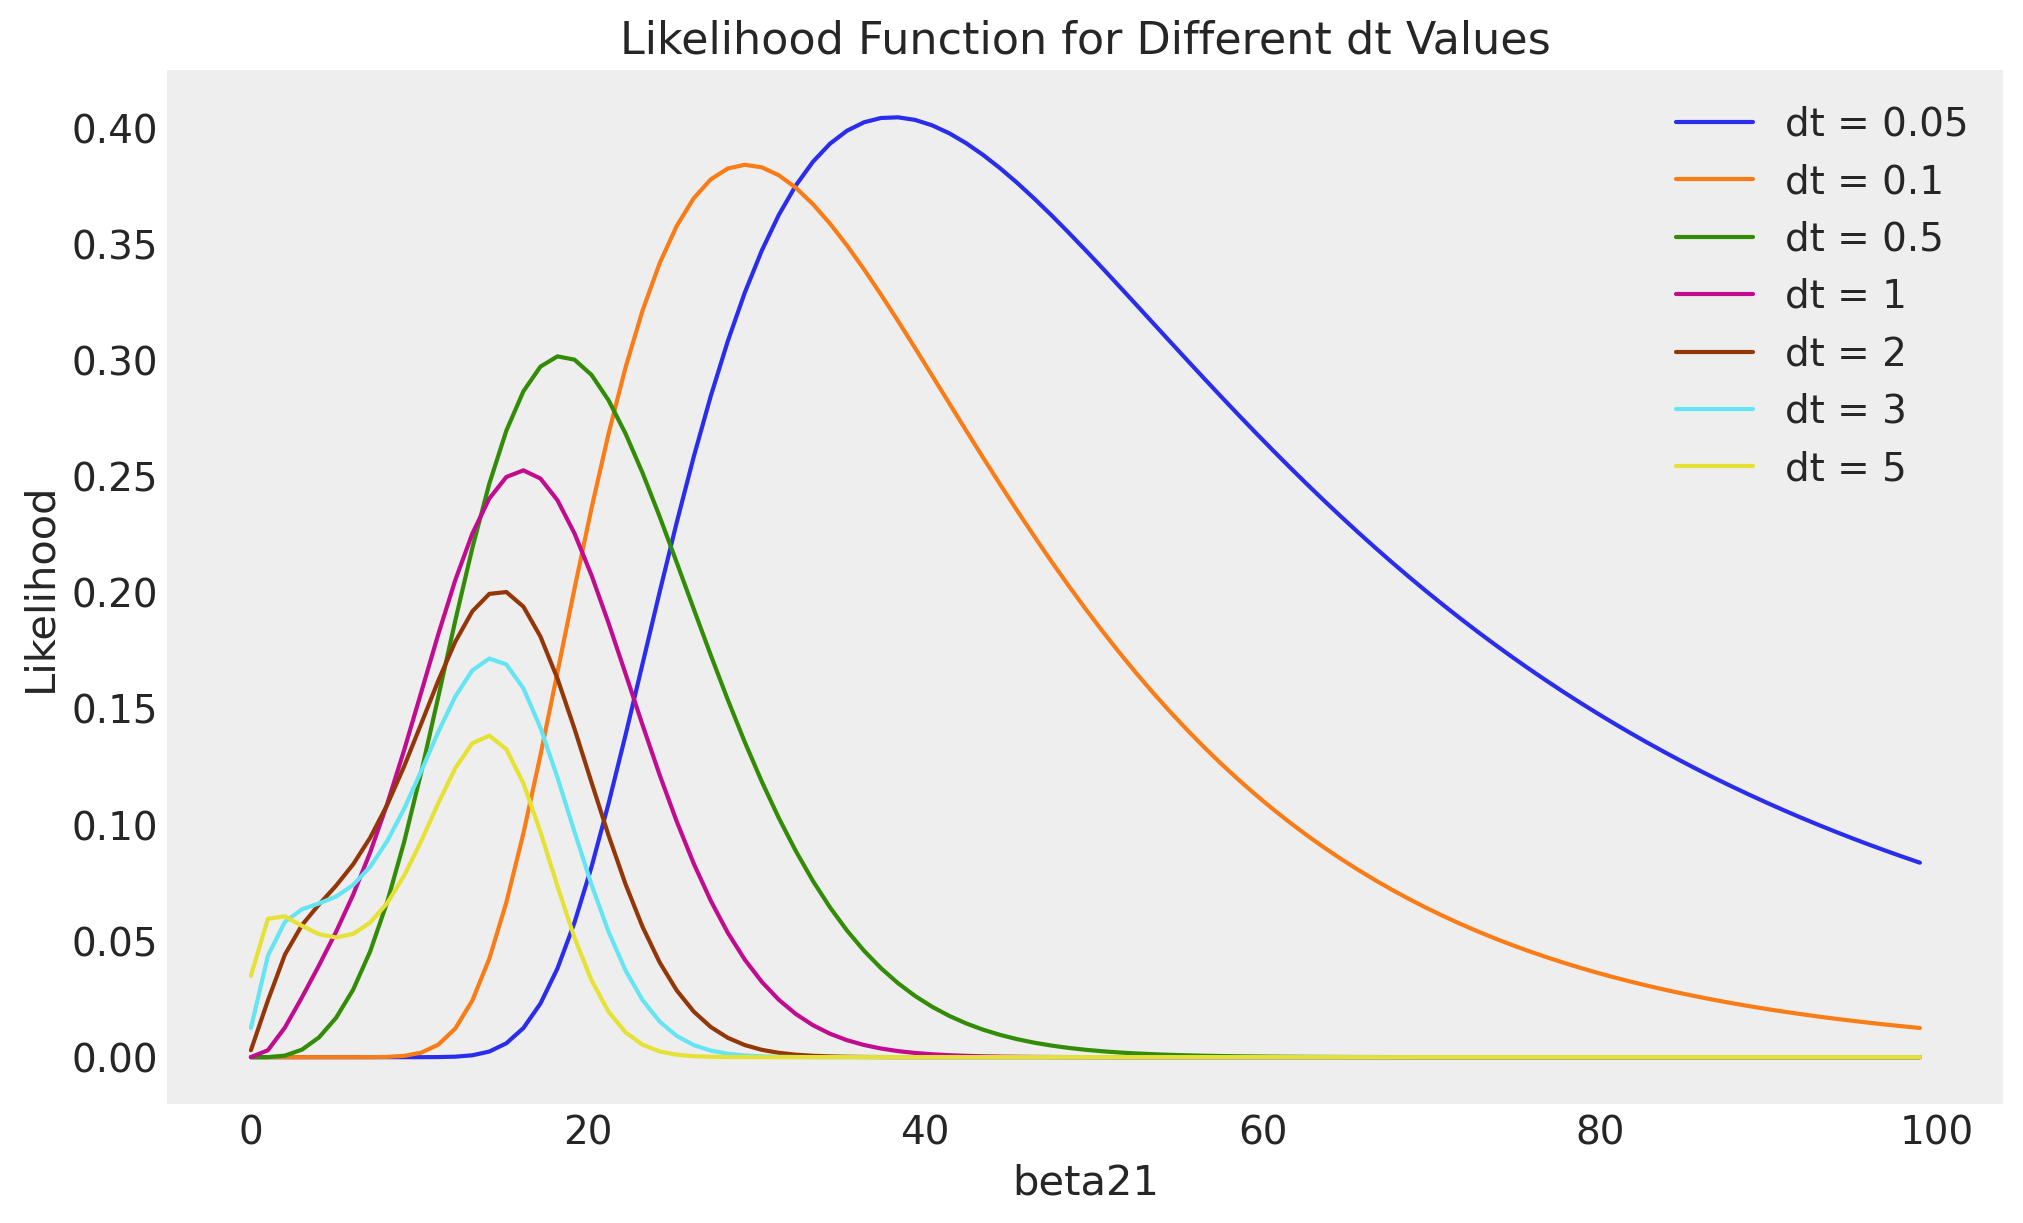

In [142]:
delta2 = 1
n, n2 = 2, 2
K1, K2 = 10, 50
beta17, beta18, beta19,beta20 = 0, 0, 0,0
beta22,beta23, beta24 = 0, 0,0

K =70 
beta21 = np.linspace(0, 100, 100)  # Ensure K has 100 points
r2 = 0
a2 = 0.01

# Independent variable ranges
x1t = np.linspace(1, 100, 100)
x2t = np.linspace(1, 100, 100)
x3t = np.linspace(1, 100, 100)
dx3t = x3t[1:] - x3t[:-1]
# Values of dt to iterate over
dt_values = [0.05,0.1, 0.5, 1, 2, 3, 5]

# Plot likelihood for each dt
plt.figure(figsize=(10, 6))
for dt in dt_values:
    # Compute F3
    F3 = dt *  (delta3*(beta17 * (x1t**n1) / (x1t**n1 + K1**n1) +
                    beta18 * (K1**n1) / (x1t**n1 + K1**n1) + 
                    beta19 * (x2t**n2) / (x2t**n2 + K2**n2) + 
                    beta20 * (K2**n2) / (x2t**n2 + K2**n2))+
        
       (1-delta3)*( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))+
        beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2))))
        
        -a3 * x3t+r3)

    # Compute G3
    G3 =  G3= np.sqrt(dt) * (
         np.sqrt(delta3*(abs(beta17 * (x1t**n1) / (x1t**n1 + K1**n1)) +
                                  abs( beta18 * (K1**n1) / (x1t**n1 + K1**n1)) +
                                  abs( beta19 * (x2t**n2) / (x2t**n2 + K2**n2)) +
                                   abs(beta20 * (K2**n2) / (x2t**n2 + K2**n2)))+
       
            (1-delta3)*(abs( beta21*(pow(x1t,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            abs( beta22*(pow(K1,n1)*pow(x2t,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            abs(beta23*(pow(x1t,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))) +
            abs(  beta24*(pow(K1,n1)*pow(K2,n2))/((pow(x1t,n1)+pow(K1,n1))*(pow(x2t,n2)+pow(K2,n2)))))+
        
        abs(a3 * x3t)+r3))
    
    F3 = F3[:-1]
    G3 = G3[:-1]  

    # Compute likelihood
    likelihood = (1 / (np.sqrt(2 * np.pi) * G3)) * np.exp(-0.5 * ((dx3t - F3) / G3)**2)

    # Plot likelihood
    plt.plot(beta21[:-1], likelihood, label=f'dt = {dt}')

# Add labels and legend
plt.xlabel('beta21')
plt.ylabel('Likelihood')
plt.title('Likelihood Function for Different dt Values')
plt.legend()
plt.grid()
plt.show()
